<a href="https://colab.research.google.com/github/sirius59/ART_AI/blob/main/ART_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Binôme T: De Carvalho Mickael et Laisney Clément

algorithme qui prédit le style de l'oeuvre d'art (impressionnisme, pop art, cubisme etc...) et peut être je dit bien PEUT ETRE 
arriver à un algorithme qui créer une oeuvre en fonction du style demandé.

jeu de données:
https://www.kaggle.com/ikarus777/best-artworks-of-all-time

points de départ: 

- réseau de convolution
- réduction de dimension pour classer 

retrouvez notre travail sur https://github.com/sirius59/ART_AI

### Import libraries

In [45]:
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, AveragePooling2D
from keras.utils import to_categorical

### Download the dataset from internet and extract it on the system

**We resized all images to 500x500 with a preview script available in the github page:** https://github.com/sirius59/ART_AI/blob/main/traitement%20des%20images.py

NB1: the csv file is a bit modified. replace space by underscore in artists names, set one genre per artists.

NB2: replace the link by a new one using this URL in case of an issue like "file is not a zipfile" https://www.mediafire.com/file/v5jpwfjeldhmc8z/dataset_resized.zip/file

In [3]:
zipurl = 'https://download1351.mediafire.com/105cn0uiabyg/v5jpwfjeldhmc8z/dataset_resized.zip'
with urlopen(zipurl) as zipresp:
  with ZipFile(BytesIO(zipresp.read())) as zfile:
    zfile.extractall()

# Core of the script

We first want to make a binary classification between 2 genre well represented in the dataset. We choose Impressionism and Baroque.

## Extracting metadata from artist.csv and labelize genres

In [4]:
artists=pd.read_csv('/content/dataset_resized/artists.csv')

##name of artists
name=artists.name

##genre of artists
genre=artists.genre

##number of paintings by artists
nb_paints=artists.paintings

Labelize a genre with a number

In [5]:
genre_label={'Impressionism':0,'Baroque':1}

In [6]:
nb_classes=len(genre_label)

Function to find the key associated with the label

In [7]:
def find_key(v): 
    for k, val in genre_label.items(): 
        if v == val: 
            return k 
    return "Key does not exist"

## Append artworks of 2 differents styles in a list
We choose 2 differents styles well represented in the dataset en choose 4 artists of each genre in order to have about 50/50 in term of artworks

In [8]:
input_shape=plt.imread(f'/content/dataset_resized/resized/{name[0]}_{1}.jpg').shape#shape of images
artworks=[]
artworks_genre=[]
genre1=(3,14,15,20,25,27,31) #selected artists in order to have ~50/50 impressionism/Baroque

for i in genre1:
  for j in range(nb_paints[i]):
    artworks.append(plt.imread(f'/content/dataset_resized/resized/{name[i]}_{j+1}.jpg'))
    artworks_genre.append(genre[i])

artworks=np.array(artworks) #images
artworks_genre=np.array(artworks_genre) #string of the genre
artworks_label=np.array([genre_label[artworks_genre[i]] for i in range(len(artworks_genre))]) #integer corresponding to the genre

We choose to represent 2 differents artworks of each genre in order to visualize datas

Text(0.5, 1.0, 'Baroque')

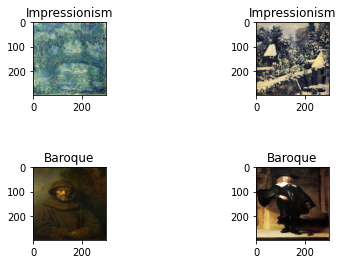

In [9]:
plt.figure()
plt.subplots_adjust(wspace=1, hspace=1)
plt.subplot(221)
plt.imshow(artworks[0])
plt.title(f'{artworks_genre[0]}')
plt.subplot(222)
plt.imshow(artworks[300])
plt.title(f'{artworks_genre[300]}')
plt.subplot(223)
plt.imshow(artworks[-1])
plt.title(f'{artworks_genre[-1]}')
plt.subplot(224)
plt.imshow(artworks[-200])
plt.title(f'{artworks_genre[-200]}')

## Shuffle and split of the dataset

In [10]:
prepared_label=to_categorical(artworks_label,num_classes=nb_classes) #convert label into a matrix eg: label 0 --> [1,0]; label 1 --> [0,1]

In [11]:
x_train,x_test,y_train,y_test=train_test_split(artworks,prepared_label, test_size=0.33, random_state=42, shuffle=True)
#split and shuffle the dataset into train and test datasets

## CNN

This is the Convolutional Network

In [27]:
model=Sequential()

model.add(Conv2D(64, kernel_size=5, activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(128, kernel_size=4, activation='relu'))
model.add(Conv2D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Dense(100, activation='relu')) #adding a Dense layer before the flatten layer drop the number of parameters

model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(nb_classes, activation='softmax'))

In [28]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 296, 296, 64)      4864      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 148, 148, 64)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 145, 145, 128)     131200    
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 143, 143, 128)     147584    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 71, 71, 128)       0         
_________________________________________________________________
dense_4 (Dense)              (None, 71, 71, 100)       12900     
_________________________________________________________________
dropout_2 (Dropout)          (None, 71, 71, 100)      

In [30]:
history=model.fit(x_train,y_train, batch_size=64, epochs=12, validation_split=0.33)

Epoch 1/12
9/9 [==============================] - 12s 1s/step - loss: 868.4990 - accuracy: 0.4750 - val_loss: 183.0927 - val_accuracy: 0.4892
Epoch 2/12
9/9 [==============================] - 11s 1s/step - loss: 145.7990 - accuracy: 0.5223 - val_loss: 7.2384 - val_accuracy: 0.6115
Epoch 3/12
9/9 [==============================] - 11s 1s/step - loss: 6.8114 - accuracy: 0.6575 - val_loss: 2.9964 - val_accuracy: 0.7302
Epoch 4/12
9/9 [==============================] - 11s 1s/step - loss: 2.1526 - accuracy: 0.7368 - val_loss: 1.0333 - val_accuracy: 0.8525
Epoch 5/12
9/9 [==============================] - 11s 1s/step - loss: 1.0596 - accuracy: 0.8322 - val_loss: 0.5679 - val_accuracy: 0.8741
Epoch 6/12
9/9 [==============================] - 11s 1s/step - loss: 0.4904 - accuracy: 0.8764 - val_loss: 0.3769 - val_accuracy: 0.8777
Epoch 7/12
9/9 [==============================] - 11s 1s/step - loss: 0.3019 - accuracy: 0.8748 - val_loss: 0.3861 - val_accuracy: 0.8849
Epoch 8/12
9/9 [============

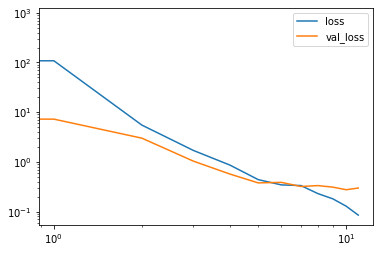

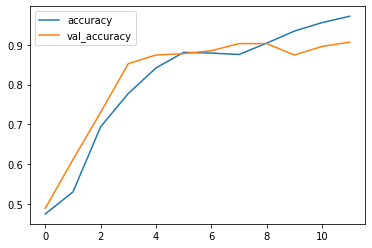

In [37]:
plt.figure()
plt.loglog(history.history['loss'],label='loss')#first values are often bigger than the rest
plt.loglog(history.history['val_loss'],label='val_loss')
plt.legend()

plt.figure()
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.legend()

In [32]:
predict=model.predict(x_test)

In [33]:
label_prediction=np.argmax(predict, axis=1)
#select the label with the highest probability eg: [0.2,0.8] --> label_prediction=1, [0.7,0.3] --> label_prediction=0
label_solution=np.argmax(y_test, axis=1)#select the label of the solution eg: [0,1] --> label_prediction=1, [1,0] --> label_prediction=0

visualisation of random predictions with solutions

Text(0.5, 1.0, 'prediction:Impressionism\n solution:Impressionism')

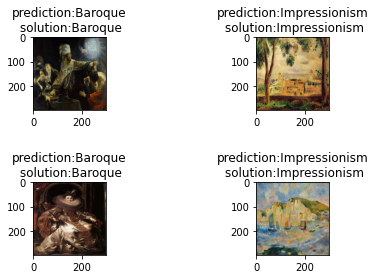

In [34]:
r1,r2,r3,r4=np.random.randint(len(y_test),size=4)
plt.figure()
plt.subplots_adjust(wspace=1, hspace=1)
plt.subplot(221)
plt.imshow(x_test[r1])
plt.title(f'prediction:{find_key(label_prediction[r1])}\n solution:{find_key(label_solution[r1])}')
plt.subplot(222)
plt.imshow(x_test[r2])
plt.title(f'prediction:{find_key(label_prediction[r2])}\n solution:{find_key(label_solution[r2])}')
plt.subplot(223)
plt.imshow(x_test[r3])
plt.title(f'prediction:{find_key(label_prediction[r3])}\n solution:{find_key(label_solution[r3])}')
plt.subplot(224)
plt.imshow(x_test[r4])
plt.title(f'prediction:{find_key(label_prediction[r4])}\n solution:{find_key(label_solution[r4])}')

In [35]:
correct=len(np.where(label_prediction==label_solution)[0]) #count the number of correct prediction
bad=len(np.where(label_prediction!=label_solution)[0]) #count the number of incorrect prediction

In [36]:
efficacity=correct/(correct+bad)
print(efficacity)

0.9154589371980676


## Add the rest of the dataset 

Labelize a genre with a number

In [50]:
k=0
genre_label={}
for i in range(len(genre)):
  if genre[i] in genre_label:#if the genre already in the dictionnary, ignore
    continue
  else:#else add it with an interger and increase it
    genre_label[genre[i]]=k
    k+=1

In [51]:
genre_label

{'Abstract Expressionism': 23,
 'Abstractionism': 1,
 'Baroque': 12,
 'Byzantine Art': 6,
 'Cubism': 11,
 'Early Renaissance': 17,
 'Expressionism': 0,
 'Fauvism': 19,
 'High Renaissance': 18,
 'Impressionism': 3,
 'Mannerism': 14,
 'Muralism': 2,
 'Neoplasticism': 21,
 'Northern Renaissance': 9,
 'Pop Art': 22,
 'Post-Impressionism': 7,
 'Primitivism': 15,
 'Proto Renaissance': 16,
 'Realism': 20,
 'Romanticism': 13,
 'Suprematism': 10,
 'Surrealism': 4,
 'Symbolism': 8,
 'impressionism': 5}

In [52]:
nb_classes=len(genre_label)

append all the images

In [53]:
input_shape=plt.imread(f'/content/dataset_resized/resized/{name[0]}_{1}.jpg').shape
artworks=[]
artworks_genre=[]
for i in range(len(name)):
  for j in range(nb_paints[i]):
    artworks.append(plt.imread(f'/content/dataset_resized/resized/{name[i]}_{j+1}.jpg'))
    artworks_genre.append(genre[i])
artworks=np.array(artworks) #images
artworks_genre=np.array(artworks_genre) #string of the genre
artworks_label=np.array([genre_label[artworks_genre[i]] for i in range(len(artworks_genre))]) #integer corresponding to the genre

plot random images

Text(0.5, 1.0, 'Expressionism')

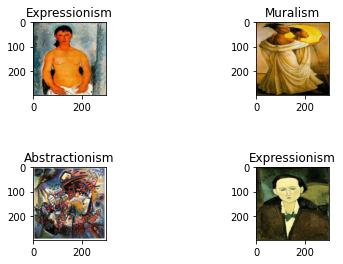

In [54]:
r1,r2,r3,r4=np.random.randint(len(y_test),size=4)
plt.figure()
plt.subplots_adjust(wspace=1, hspace=1)
plt.subplot(221)
plt.imshow(artworks[r1])
plt.title(f'{artworks_genre[r1]}')
plt.subplot(222)
plt.imshow(artworks[r2])
plt.title(f'{artworks_genre[r2]}')
plt.subplot(223)
plt.imshow(artworks[r3])
plt.title(f'{artworks_genre[r3]}')
plt.subplot(224)
plt.imshow(artworks[r4])
plt.title(f'{artworks_genre[r4]}')

Some genre are over represented so we reduce this in the section bellow

In [113]:
list_genre=list(genre_label.keys())
nb_aw_per_genre=min(nb_paints)
artworks=[]
artworks_genre=[]

for i in list_genre:
  index_genre=np.where(genre==i)[0]
  for j in index_genre: #for each genre for each artists it select randomly a fraction of artworks
    R=np.random.randint(1,nb_paints[j]+1,size=(nb_aw_per_genre//len(index_genre)))
    for k in R:
      artworks.append(plt.imread(f'/content/dataset_resized/resized/{name[j]}_{k}.jpg'))
      artworks_genre.append(i)
artworks=np.array(artworks) #images
artworks_genre=np.array(artworks_genre) #string of the genre
artworks_label=np.array([genre_label[artworks_genre[i]] for i in range(len(artworks_genre))]) #integer corresponding to the genre

Matrix of the labels

In [55]:
prepared_label=to_categorical(artworks_label,num_classes=nb_classes)

Shuffle and split of the dataset

In [56]:
x_train,x_test,y_train,y_test=train_test_split(artworks,prepared_label, test_size=0.33, random_state=42, shuffle=True)

In [58]:
model=Sequential()

model.add(Conv2D(64, kernel_size=5, activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(128, kernel_size=4, activation='relu'))
model.add(Conv2D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Flatten())

model.add(Dense(100, activation='relu'))

model.add(Dropout(0.25))

model.add(Dense(nb_classes, activation='softmax'))

In [59]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [60]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 296, 296, 64)      4864      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 148, 148, 64)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 145, 145, 128)     131200    
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 143, 143, 128)     147584    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 71, 71, 128)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 645248)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)              

In [63]:
history=model.fit(x_train,y_train, batch_size=64, epochs=10, validation_split=0.33)

Epoch 1/10
60/60 [==============================] - 71s 1s/step - loss: 1.4236 - accuracy: 0.5778 - val_loss: 6.2718 - val_accuracy: 0.1660
Epoch 2/10
60/60 [==============================] - 70s 1s/step - loss: 1.3147 - accuracy: 0.6148 - val_loss: 5.9864 - val_accuracy: 0.1622
Epoch 3/10
60/60 [==============================] - 71s 1s/step - loss: 1.2302 - accuracy: 0.6398 - val_loss: 7.5907 - val_accuracy: 0.1574
Epoch 4/10
60/60 [==============================] - 71s 1s/step - loss: 1.1601 - accuracy: 0.6617 - val_loss: 8.2568 - val_accuracy: 0.1595
Epoch 5/10
60/60 [==============================] - 71s 1s/step - loss: 1.1088 - accuracy: 0.6815 - val_loss: 8.4650 - val_accuracy: 0.1574
Epoch 6/10
60/60 [==============================] - 71s 1s/step - loss: 1.0785 - accuracy: 0.6860 - val_loss: 7.9112 - val_accuracy: 0.1622
Epoch 7/10
60/60 [==============================] - 71s 1s/step - loss: 1.0634 - accuracy: 0.6918 - val_loss: 9.0115 - val_accuracy: 0.1563
Epoch 8/10
60/60 [==

In [64]:
predict=model.predict(x_test)

In [65]:
label_prediction=np.argmax(predict, axis=1)
label_solution=np.argmax(y_test, axis=1)

Text(0.5, 1.0, 'prediction:Surrealism\n solution:Expressionism')

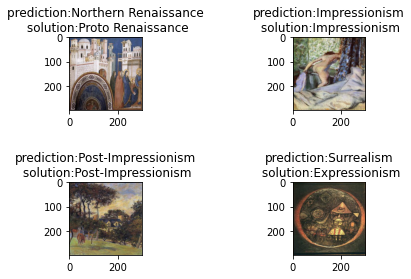

In [66]:
r1,r2,r3,r4=np.random.randint(len(y_test),size=4)
plt.figure()
plt.subplots_adjust(wspace=1, hspace=1)
plt.subplot(221)
plt.imshow(x_test[r1])
plt.title(f'prediction:{find_key(label_prediction[r1])}\n solution:{find_key(label_solution[r1])}')
plt.subplot(222)
plt.imshow(x_test[r2])
plt.title(f'prediction:{find_key(label_prediction[r2])}\n solution:{find_key(label_solution[r2])}')
plt.subplot(223)
plt.imshow(x_test[r3])
plt.title(f'prediction:{find_key(label_prediction[r3])}\n solution:{find_key(label_solution[r3])}')
plt.subplot(224)
plt.imshow(x_test[r4])
plt.title(f'prediction:{find_key(label_prediction[r4])}\n solution:{find_key(label_solution[r4])}')

In [67]:
correct=len(np.where(label_prediction==label_solution)[0])
bad=len(np.where(label_prediction!=label_solution)[0])

In [68]:
efficacity=correct/bad
print(efficacity)

0.19708029197080293
